In [1]:
import transformers 
import torch

/home/ksmehrab/miniconda/envs/easyr1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor

In [3]:
# default: Load the model on the available device(s)
# MODEL_PATH = "/data/VLMGroundingProject/PretrainedModels/Qwen3-VL-4B-Thinking"
MODEL_PATH = "/data/VLMGroundingProject/PretrainedModels/Qwen3-VL-8B-Thinking"
# model = Qwen3VLForConditionalGeneration.from_pretrained(
#     MODEL_PATH, dtype="auto", device_map="auto", local_files_only=True
# )

In [4]:
# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
model = Qwen3VLForConditionalGeneration.from_pretrained(
    MODEL_PATH,
    dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map="auto",
    local_files_only=True
)

processor = AutoProcessor.from_pretrained(MODEL_PATH)

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg",
            },
            {"type": "text", "text": "Describe this image."},
        ],
    }
]

# Preparation for inference
inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt"
)
inputs = inputs.to(model.device)

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


In [5]:
output_text = processor.batch_decode(
    generated_ids, skip_special_tokens=False, clean_up_tokenization_spaces=False
)
print(output_text)

["<|im_start|>user\n<|vision_start|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|

## Evaluation Code 

In [4]:
import os 
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

import sys
sys.path.append('/home/ksmehrab/AttentionGrounding/ModelPlaygrounds/SegZero/GitRepoLatest/Seg-Zero')
sys.path.append('/home/ksmehrab/AttentionGrounding/ModelPlaygrounds/SegZero/EvaluationScripts')

import torch
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
from sam2.sam2_image_predictor import SAM2ImagePredictor
import re

import argparse

from eval_base import (
    extract_bbox_points_think,
    extract_information_vrpart,
    extract_information_vrpart2,
    compute_iou,
    combine_masks,
    visualize_first_and_final_bbox
)


In [5]:
import matplotlib.pyplot as plt
from PIL import Image

def visualize_bbox(image, bbox, label="", color='red', linewidth=2):
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)
    
    # Extract bbox coordinates
    x1, y1, x2, y2 = bbox
    
    # Create rectangle
    from matplotlib.patches import Rectangle
    rect = Rectangle((x1, y1), x2-x1, y2-y1, 
                     linewidth=linewidth, 
                     edgecolor=color, 
                     facecolor='none')
    ax.add_patch(rect)
    
    # Add label if provided
    if label:
        ax.text(x1, y1-5, label, 
               color=color, 
               fontsize=12, 
               bbox=dict(facecolor='white', alpha=0.7))
    
    ax.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
def scale_bbox(bbox, x_factor, y_factor):
    x1, y1, x2, y2 = bbox
    x1_scaled = int(x1 * x_factor)
    y1_scaled = int(y1 * y_factor)
    x2_scaled = int(x2 * x_factor)
    y2_scaled = int(y2 * y_factor)
    return [x1_scaled, y1_scaled, x2_scaled, y2_scaled]

In [7]:
############# Dataset-specific settings #############
instructpart_test_dir = "/data/VLMGroundingProject/Datasets/InstructPart/test"
masks_dir = os.path.join(instructpart_test_dir, "masks")
images_dir = os.path.join(instructpart_test_dir, "images")
val_filenames = os.listdir(images_dir)
######################################################

In [8]:
prompt_filepath = '/home/ksmehrab/AttentionGrounding/ModelPlaygrounds/SegZero/EvaluationScripts/Prompts/vrpart2_prompt.txt'
with open(prompt_filepath, 'r') as f:
    QUESTION_TEMPLATE = f.read()
llm_output_parser = extract_information_vrpart2

In [9]:
##### Dataset-specific function #####
def load_mask_and_parse_name(image_name, masks_dir):
    """
    load mask and extract object and part names from filename for instructpart dataset
    
    args:
        image_name: name of the image file (with or without extension)
        masks_dir: directory containing the mask files
    
    returns:
        mask: loaded mask as numpy array
        object_name: name of the object
        part_name: name of the part
    """
    basename = os.path.splitext(image_name)[0]
    
    mask_path = os.path.join(masks_dir, f"{basename}.png")
    mask = np.array(Image.open(mask_path))
    
    # parse filename: image_id-object_name-part_name
    filename_parts = basename.split('-')
    part_name = filename_parts[-1]
    object_name = filename_parts[-2]

    return mask, object_name, part_name
#######################################


In [10]:
reasoning_model_path = "/data/VLMGroundingProject/PretrainedModels/Qwen3-VL-8B-Thinking"
max_response_length = 2000

In [ ]:
# load models
reasoning_model = Qwen3VLForConditionalGeneration.from_pretrained(
    reasoning_model_path, # CHANGE
    dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map="auto",
    local_files_only=True
)
reasoning_model.eval()

In [12]:
processor = AutoProcessor.from_pretrained(reasoning_model_path, padding_side="left")


In [24]:
prediction_grid_size = 1000
resize_size = 1024
batch_messages = []
batch_metadata = []
for image_name in val_filenames[4:5]:  # process only first n images for demo
    # Load image
    img_filepath = os.path.join(images_dir, image_name)
    image = Image.open(img_filepath).convert("RGB")
    original_width, original_height = image.size

    x_factor, y_factor = original_width/prediction_grid_size, original_height/prediction_grid_size

    # Load ground truth mask and parse names
    gt_mask, object_name, part_name = load_mask_and_parse_name(image_name, masks_dir)
    # print(f"Image: {image_name}, Object: {object_name}, Part: {part_name}")
    # Create query text (part within object)
    query_text = f"{object_name}'s {part_name}"
    
    # Prepare message for model
    message = [{
        "role": "user",
        "content": [
            {
                "type": "image", 
                "image": image.resize((resize_size, resize_size), Image.BILINEAR)
            },
            {   
                "type": "text",
                "text": QUESTION_TEMPLATE.format(Question=query_text.lower().strip("."))
            }
        ]
    }]

    batch_messages.append(message)
    batch_metadata.append({
        "image_name": image_name,
        "image": image,
        "original_width": original_width,
        "original_height": original_height,
        "x_factor": x_factor,
        "y_factor": y_factor,
        "gt_mask": gt_mask,
        "object_name": object_name,
        "part_name": part_name,
        "query_text": query_text
    })

In [25]:
batch_messages[0][0]['content'][0]['image'].size

(1024, 1024)

In [26]:
# inputs
inputs = processor.apply_chat_template(
    batch_messages,
    tokenize=True,
    padding=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt"
).to("cuda")

In [27]:
# generate output
with torch.inference_mode():
    generated_ids = reasoning_model.generate(**inputs, use_cache=True, max_new_tokens=max_response_length, do_sample=False)

    generated_ids_trimmed = [out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
    output_texts = processor.batch_decode(generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False)


In [ ]:
print(output_texts[0])

Got it, let's tackle this problem step by step. First, the query is "cup's body". So we need to identify the body of the cup. 

Step 1: Think. The query is asking for the "cup's body", which is a part of the cup. The cup is the whole object, and the body is the main part excluding the handle. So first, we need to find the cup (the whole object) and then determine the body part.

Step 2: Decide if it's an object or part. Since it's "cup's body", it's a part of the cup. So target is "part".

Step 3: If it's a part, find the whole object (cup) that contains the part. The cup is the white mug. So we need to find the bounding box of the cup (the whole object) first. The cup includes the handle, so the whole cup's bounding box would be from the leftmost point of the handle to the rightmost point of the cup, top to bottom.

Looking at the image: the cup is white, with a handle on the left. The cup's body is the main cylindrical part, not including the handle. Wait, but the query is "cup's bod

: 

In [21]:
output_text_manual = """<target>part</target>
<object_hint>[{"bbox_2d": [290, 85, 650, 910], "point_2d": [470, 500]}]</object_hint>
<first_answer>[{"bbox_2d": [500, 85, 650, 350], "point_2d": [575, 200]}]</first_answer>
<criticism>The bounding box for the tines is tight and correctly placed around the four prongs. The point is inside the tines. ADJUSTMENT: NO</criticism>
<answer>[{"bbox_2d": [500, 85, 650, 350], "point_2d": [575, 200]}]</answer>"""
bboxes, points, parsed_output = extract_information_vrpart2(output_text_manual, x_factor, y_factor)

In [19]:
image.size # original image size, but in our msg, we resized to 1024. so we expect the predicted bbox to be in 1024x1024 scale
# in this case, the original size is also 1024 

(1024, 1024)

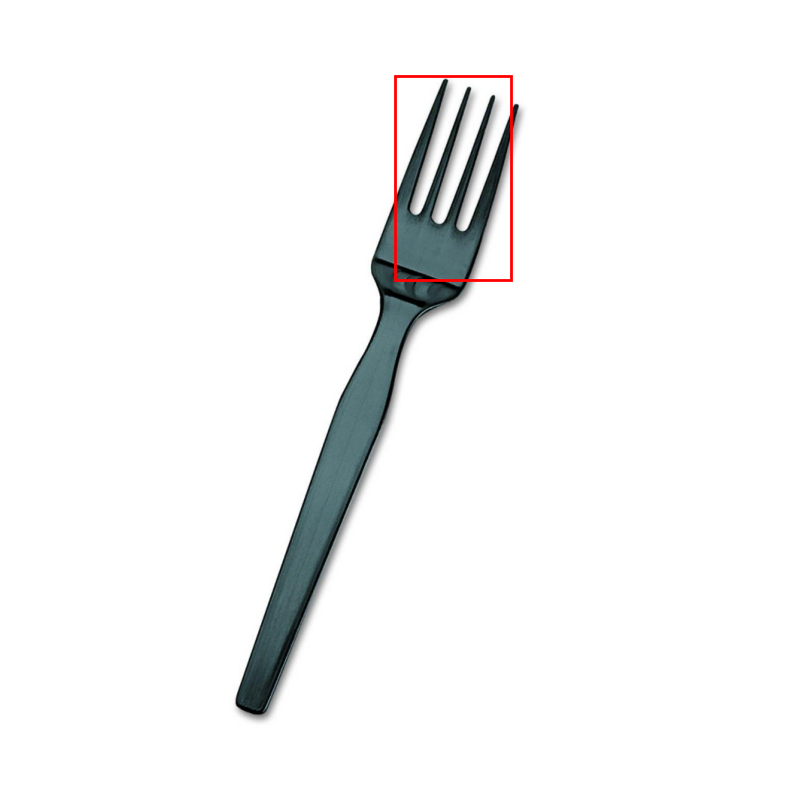

In [23]:
visualize_bbox(image, bboxes[0])

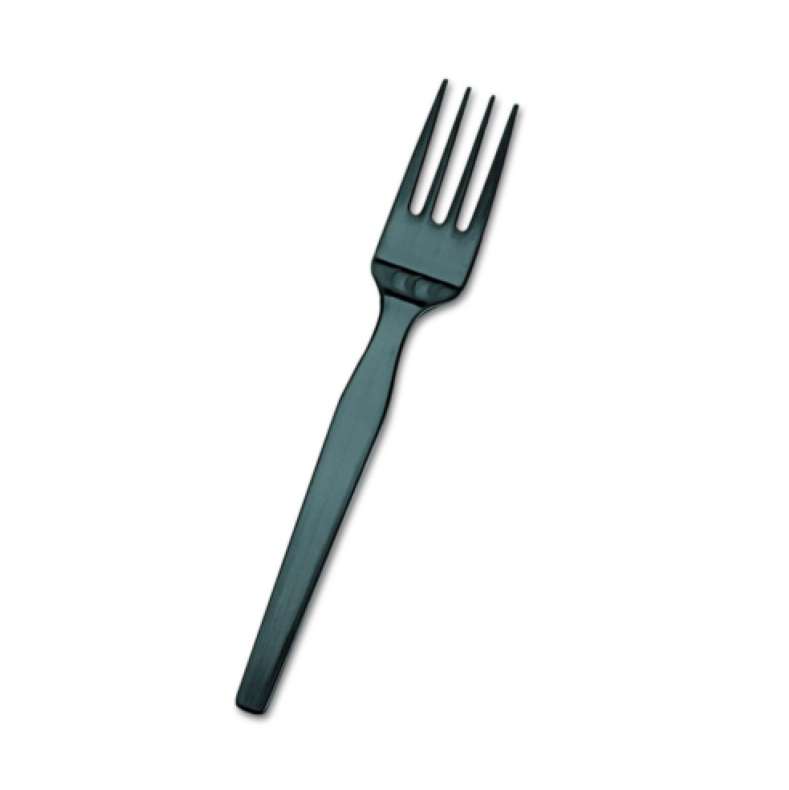

In [121]:
visualize_bbox(image.resize((resize_size, resize_size), Image.BILINEAR), [484, 87, 664, 374])

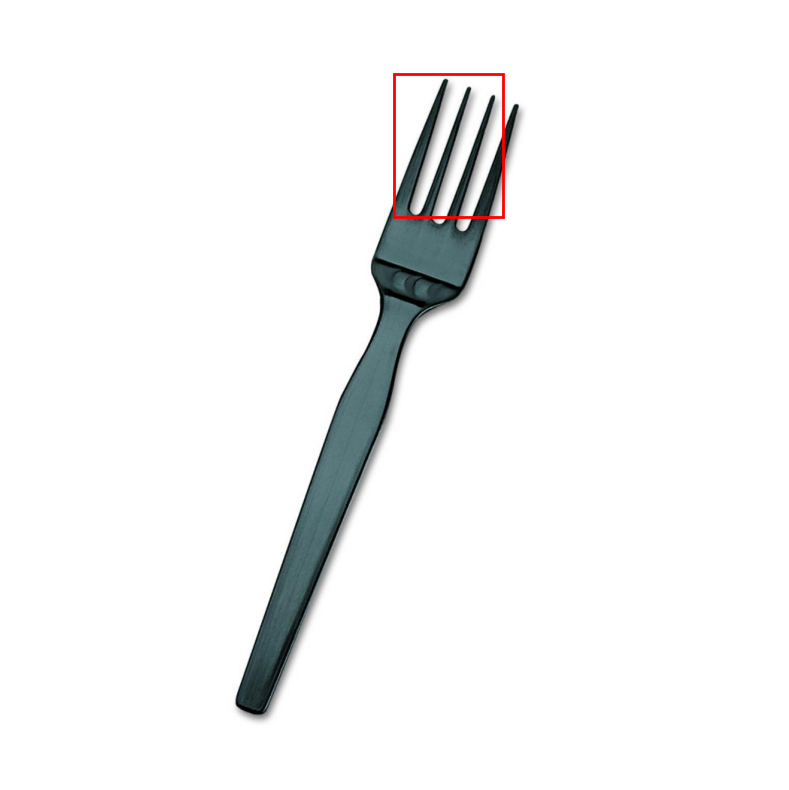

In [110]:
# but smh the predicted box is in the original image scale
visualize_bbox(image, [510, 85, 655, 275])

In [111]:
scaled_bbox_to_original_size = scale_bbox([510, 85, 655, 275], image.size[0]/resize_size, image.size[1]/resize_size)

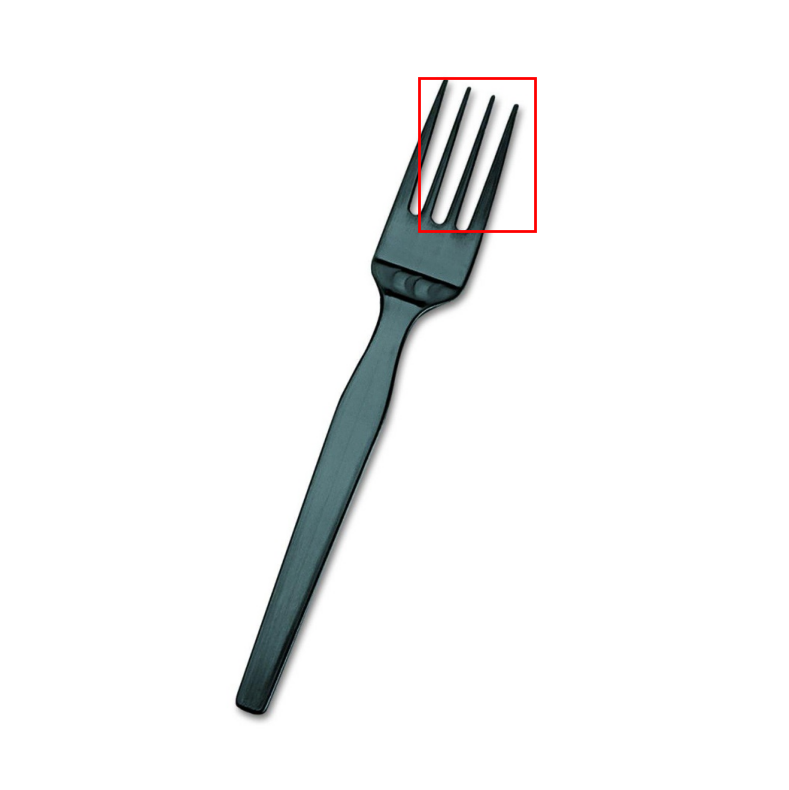

In [112]:
visualize_bbox(image, scaled_bbox_to_original_size)

In [122]:
from qwen_vl_utils import smart_resize

In [123]:
resized_h, resized_w = smart_resize(image.size[1], image.size[0], factor=32, min_pixels=262144, max_pixels=4194304)

In [ ]:
# qwen3-vl expects images to be resized to a multiple of 32
# the output is in a 1000 x 1000 grid

In [ ]:
# during training, we can create the dataset so that the GT boxes are in the resized and 1000 x 1000 grid 
# for training:
## we can change the dataset.py, where we return the image data "example". we can have the original image in the column, get its size, get the smart_resized size, and then resize the image accordingly
## for reward, since the GT box is in 1000 x 1000 grid, and the predictions will also be in 1000 x 1000 grid, we can directly compute iou without any scaling
## for inference, we can resize the image to the smart_resized size, pass it through the model, get the output in the 1000 x 1000 grid, and then scale it back to the original image size for visualization and evaluation